<a href="https://colab.research.google.com/github/casjunior93/Projeto-Tera-IA---Previsao-de-obitos-por-covid-considerando-doencas-pre-existentes/blob/main/Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Habilitando o acesso ao Google Drive no Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bibliotecas fundamentais

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os 
import missingno as msno

#Não exibir avisos de atenção
import warnings
warnings.filterwarnings('ignore')

#Configura o pandas para não exibir resultados em notação científica
pd.options.display.float_format = '{:.5f}'.format

# 1 Importação e visualização dos dados

## 1.1 Importação dos dados

In [4]:
%%time
df_ml = pd.read_csv('/content/drive/MyDrive/ANÁLISES DE DADOS/Covid/df_pronto.csv', sep=',', encoding='utf-8')

CPU times: user 26.1 ms, sys: 14.3 ms, total: 40.4 ms
Wall time: 72.2 ms


In [5]:
df_ml.head(5)

,idade,cs_sexo,obito,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,pneumopatia
0,69.00000,1,0,0,1,0,0,0,0,0,0,0,0
1,69.00000,0,0,0,0,0,0,0,0,0,0,1,1
2,73.00000,1,0,0,0,1,0,0,0,0,0,0,0
3,61.00000,0,0,0,1,0,0,0,0,0,0,0,0
4,31.00000,0,0,0,0,0,0,0,0,0,0,1,0


## 1.2 Análise de correlação

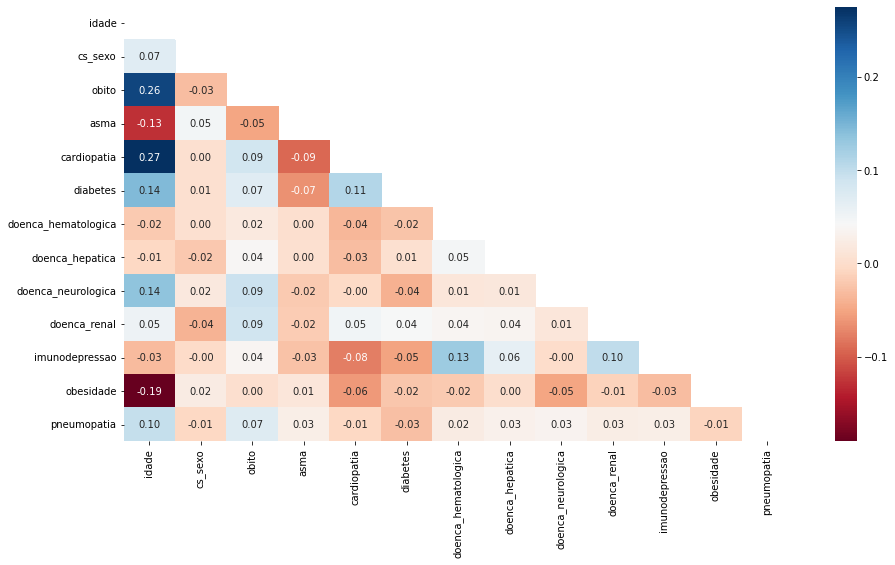

CPU times: user 806 ms, sys: 149 ms, total: 955 ms
Wall time: 866 ms


In [6]:
%%time
sns.set_context(font_scale=1.9)
plt.figure(figsize=(15,8))
sns.heatmap(
    df_ml.corr(), annot=True, fmt='.2f', cmap='RdBu', mask=np.triu(np.ones_like(df_ml.corr())))
plt.show()

* A feature idade tem uma correlação positiva com a feature obito.
* A feature idade tem uma correlação positiva com cardiopatia.

## 1.3 Visualização da variável target

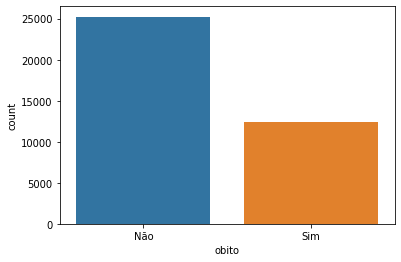

In [7]:
g = sns.countplot(df_ml['obito'])
g.set_xticklabels(['Não', 'Sim'])
plt.show()

## 1.4 Normalização da feature idade e Feature Engineering

### 1.4.1 Normalização

In [8]:
%%time

df_ml_bk = df_ml.copy()

from sklearn.preprocessing import MinMaxScaler

coluna = np.array(df_ml['idade']).reshape(-1,1)
df_ml['idade_norm'] = MinMaxScaler().fit_transform(coluna)

CPU times: user 121 ms, sys: 13 ms, total: 134 ms
Wall time: 190 ms


In [9]:
df_ml.head()

,idade,cs_sexo,obito,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,pneumopatia,idade_norm
0,69.00000,1,0,0,1,0,0,0,0,0,0,0,0,0.65094
1,69.00000,0,0,0,0,0,0,0,0,0,0,1,1,0.65094
2,73.00000,1,0,0,0,1,0,0,0,0,0,0,0,0.68868
3,61.00000,0,0,0,1,0,0,0,0,0,0,0,0,0.57547
4,31.00000,0,0,0,0,0,0,0,0,0,0,1,0,0.29245


### 1.4.2 Criando uma feature de quantidade de doenças por registro

In [10]:
df_ml.columns

Index(['idade', 'cs_sexo', 'obito', 'asma', 'cardiopatia', 'diabetes',
       'doenca_hematologica', 'doenca_hepatica', 'doenca_neurologica',
       'doenca_renal', 'imunodepressao', 'obesidade', 'pneumopatia',
       'idade_norm'],
      dtype='object')

In [11]:
df_ml['quantidade_doencas'] = df_ml.iloc[:,3:13].sum(axis=1)

In [12]:
df_ml.head(2)

,idade,cs_sexo,obito,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,pneumopatia,idade_norm,quantidade_doencas
0,69.00000,1,0,0,1,0,0,0,0,0,0,0,0,0.65094,1
1,69.00000,0,0,0,0,0,0,0,0,0,0,1,1,0.65094,2


## 1.5 Separando em datasets de features e target

In [13]:
df_ml.columns

Index(['idade', 'cs_sexo', 'obito', 'asma', 'cardiopatia', 'diabetes',
       'doenca_hematologica', 'doenca_hepatica', 'doenca_neurologica',
       'doenca_renal', 'imunodepressao', 'obesidade', 'pneumopatia',
       'idade_norm', 'quantidade_doencas'],
      dtype='object')

In [14]:
X = df_ml[['idade_norm', 'cs_sexo', 'asma', 'cardiopatia', 'diabetes',
       'doenca_hematologica', 'doenca_hepatica', 'doenca_neurologica',
       'doenca_renal', 'imunodepressao', 'obesidade', 'pneumopatia', 'quantidade_doencas']]

In [15]:
y = df_ml['obito']

In [16]:
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    shuffle=True)

# 2 - Testando modelos

## 2.1 Importando LazyPredict

[Tutorial 1](https://towardsdatascience.com/lazy-predict-fit-and-evaluate-all-the-models-from-scikit-learn-with-a-single-line-of-code-7fe510c7281).

[Tutorial 2](https://www.analyticsvidhya.com/blog/2021/05/lazy-predict-best-suitable-model-for-you/).

In [17]:
#!pip install lazypredict

In [18]:
import lazypredict

In [19]:
from lazypredict.Supervised import LazyClassifier

## 2.2 Treinando os modelos

In [ ]:
%%time
clf = LazyClassifier(predictions=True, verbose=0, ignore_warnings=True, custom_metric = 'precision')
models, predictions = clf.fit(X_treino, X_teste, y_treino, y_teste)

 41%|████▏     | 12/29 [00:57<02:51, 10.08s/it]